In [13]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import seaborn as sns
import pickle

from Nested_CV import NESTED_CV

In [14]:
################ Global Variables ##############################################
data_file_path = "8_Master_Formulas.csv"
formulation_param_names = ['NP_ratio', 'Dlin-MC3_Helper lipid_ratio',
                      'Dlin-MC3+Helper lipid percentage', 'Chol_DMG-PEG_ratio']
helper_lipid_names = ['18PG', 'DOPE','DOTAP','DSPC', '14PA', 'DDAB']
lipid_param_names = ['P_charged_centers', 'N_charged_centers', 'cLogP', 'cTPSA',
                      'Hbond_D', 'Hbond_A', 'Total_Carbon_Tails', 'Double_bonds']

input_param_names = lipid_param_names +  formulation_param_names 

[[ 3.    5.    0.01  2.  ]
 [ 4.   12.    0.13  3.  ]
 [ 1.    2.    0.17  2.  ]
 [ 0.    6.    0.37  2.  ]
 [13.   14.    0.52  5.  ]
 [ 7.   15.    0.76  3.  ]
 [ 8.    9.    1.    2.  ]
 [10.   18.    1.    3.  ]
 [11.   19.    1.    4.  ]
 [16.   17.    1.21  8.  ]
 [20.   21.    1.58 12.  ]]


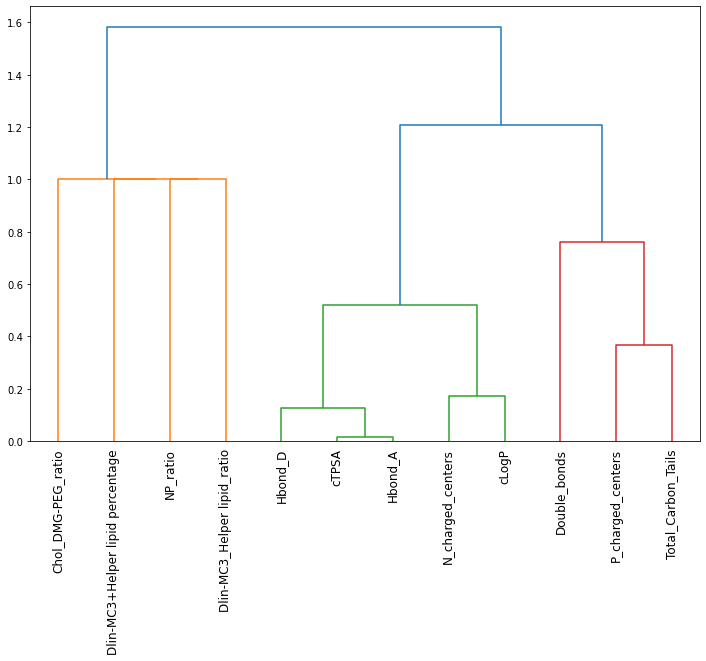

In [15]:
df = pd.read_csv(data_file_path)

# Formatting Training Data
X = df[input_param_names]
X = X.dropna()  # Remove any NaN rows

X.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(12, 8))

corr = spearmanr(X).correlation  # generate a correlation matrix is symmetric
corr = (corr + corr.T) / 2  # ensure the correlation matrix is symmetric
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)  # convert the correlation matrix to a distance matrix
dist_linkage = hierarchy.ward(squareform(distance_matrix))  # generate Ward's linkage values for hierarchical clustering

# Print dist_linkage without scientific notation
np.set_printoptions(precision=2, suppress=True)
print(dist_linkage)
#save as csv
np.savetxt("dist_linkage.csv", dist_linkage, delimiter=",")

dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.tolist(), leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))


In [16]:
###Define Clusters for Feature Reduction ### 
clusters = [['cTPSA','Hbond_A'],
            ['cTPSA','Hbond_A','Hbond_D'],
            ['N_charged_centers', 'cLogP'],
            ['P_charged_centers','Total_Carbon_Tails'],
            ['cTPSA','Hbond_A','Hbond_D','N_charged_centers', 'cLogP'],
            ['P_charged_centers','Total_Carbon_Tails','Double_bonds'],
            ['NP_ratio', 'Dlin-MC3_Helper lipid_ratio'],
            ['NP_ratio', 'Dlin-MC3_Helper lipid_ratio','Dlin-MC3+Helper lipid percentage'],
            ['NP_ratio', 'Dlin-MC3_Helper lipid_ratio','Dlin-MC3+Helper lipid percentage', 'Chol_DMG-PEG_ratio'],  
            ['P_charged_centers','Total_Carbon_Tails','Double_bonds','cTPSA','Hbond_A','Hbond_D','N_charged_centers', 'cLogP'],
            ]

In [17]:
def run_NESTED_CV(model_name, data_file_path, save_path, cell, wt_percent, size_zeta, CV,input_param_names, feature):

  """
  Function that:
  - runs the NESTED_CV for a desired model in the class, cell type, and for a given number of folds
  - default is 10-folds i.e., CV = None. CV = # Trials... # outerloop repeats
  - prints status and progress of NESTED_CV
  - formats the results as a datafarme, and saves them locally
  - assigns the best HPs to the model, trains, and saves its locally
  - then returns the results dataframe and the saved model
  """
  if __name__ == '__main__':
    model_instance = NESTED_CV(data_file_path, model_name)
    model_instance.input_target(cell,size_zeta, input_param_names)
    model_instance.cross_validation(CV)
    model_instance.results()
    model_instance.best_model() 

    
    # Save Tuning Results CSV
    with open(save_path + f'{cell}/' + str(len(input_param_names)) + "_TotalFeatures_" + feature + 'Preserved' + '_HP_Tuning_Results.csv', 'w', encoding = 'utf-8-sig') as f: #Save file to csv
      model_instance.CV_dataset.to_csv(f)
    
    # Save Tuning Results PKL
    model_instance.CV_dataset.to_pickle(save_path + f'{cell}/' +str(len(input_param_names)) + "_TotalFeatures_" + feature + 'Preserved' + '_HP_Tuning_Results.pkl', compression='infer', protocol=5, storage_options=None) 
    
    # Save the Model to pickle file
    with open(save_path + f'{cell}/' + str(len(input_param_names)) + "_TotalFeatures_" + feature + 'Preserved' + '_Trained.pkl', 'wb') as file: 
          pickle.dump(model_instance.best_model, file)

    # Save the Training Data used to .pkl
    with open(save_path + f'{cell}/' +str(len(input_param_names)) + "_TotalFeatures_" + feature + 'Preserved' + '_Training_Data.pkl', 'wb') as file:
          pickle.dump(model_instance.cell_data, file)

    # Save the Training Data used to csv
    with open(save_path + f'{cell}/' +str(len(input_param_names)) + "_TotalFeatures_" + feature + 'Preserved' + '_Training_Data.csv', 'w', encoding = 'utf-8-sig') as file:
          model_instance.cell_data.to_csv(file)
    
    print('Sucessfully save NESTED_CV Results, Final Model, and Training dataset')
    return model_instance

In [18]:
import matplotlib.pyplot as plt

#define a function called plot_feature_reduction 
def plot_feature_reduction(stats_df, cell_type):

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 5), facecolor='white')
    ax2 = ax1.twinx()

    # Plot the points with error bars for Average MAE
    ax1.errorbar(stats_df['Feature_No'], stats_df['Average MAE'], yerr=stats_df['Std MAE'], fmt='o', color='black',
                ecolor='darkgray', elinewidth=2, capsize=4, capthick=2, label='Average MAE')

    # Draw a line connecting the points for Average MAE
    ax1.plot(stats_df['Feature_No'], stats_df['Average MAE'], color='blue', linewidth=1)

    # Plot error bars for Spearman correlation coefficient
    ax2.errorbar(stats_df['Feature_No'], stats_df['Average Spearman'], yerr=stats_df['Std Spearman'], fmt='o', color='red',
                ecolor='darkgray', elinewidth=2, capsize=4, capthick=2, label='Average Spearman')

    # Draw a line connecting the points for Spearman correlation coefficient
    ax2.plot(stats_df['Feature_No'], stats_df['Average Spearman'], color='red', linewidth=1)

    # Plot error bars for Pearson correlation coefficient
    ax2.errorbar(stats_df['Feature_No'], stats_df['Average Pearson'], yerr=stats_df['Std Pearson'], fmt='o', color='green',
                ecolor='darkgray', elinewidth=2, capsize=4, capthick=2, label='Average Pearson')

    # Draw a line connecting the points for Pearson correlation coefficient
    ax2.plot(stats_df['Feature_No'], stats_df['Average Pearson'], color='green', linewidth=1)

    # Set labels for the x-axis and y-axes
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Average MAE')
    ax2.set_ylabel('Correlation Coefficients')

    # Reverse the x-axis
    ax1.invert_xaxis()

    # Adjust font size and style
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12

    # Set integer labels on the x-axis
    ax1.set_xticks(range(int(stats_df['Feature_No'].min()), int(stats_df['Feature_No'].max()) + 1))

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='upper left')

    # Update the legend titles
    ax1.legend(lines, ['Average MAE', 'Average Spearman', 'Average Pearson'], loc='center left')

    # Save the plot as a high-resolution image (e.g., PNG or PDF)
    plt.savefig(f'{cell_type}_Feature_Reduction_Plot.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


Input Parameters used: ['P_charged_centers', 'N_charged_centers', 'cLogP', 'cTPSA', 'Hbond_D', 'Hbond_A', 'Total_Carbon_Tails', 'Double_bonds', 'NP_ratio', 'Dlin-MC3_Helper lipid_ratio', 'Dlin-MC3+Helper lipid percentage', 'Chol_DMG-PEG_ratio']
# of Input Parameters used: 12
Number of Datapoints used: 720

################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.088, Hold_Out_MAE: 0.085,  Hold_Out_Spearman_Rank: 0.889, Hold_Out_Pearsons_R: 0.891, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0.015, 'reg_alpha': 0.01, 'num_leaves': 16, 'n_estimators': 200, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.084, Hold_Out_MAE: 0.091,  Hold_Out_Spearman_Rank: 

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.087, Hold_Out_MAE: 0.087,  Hold_Out_Spearman_Rank: 0.891, Hold_Out_Pearsons_R: 0.889, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.015, 'reg_alpha': 0, 'num_leaves': 16, 'n_estimators': 100, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.083, Hold_Out_MAE: 0.087,  Hold_Out_Spearman_Rank: 0.859, Hold_Out_Pearsons_R: 0.868, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.005, 'reg_alpha': 0, 'num_leaves': 128, 'n_estimators': 600, 'min_child_weight': 0.001, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'dart'}

##########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.086, Hold_Out_MAE: 0.088,  Hold_Out_Spearman_Rank: 0.883, Hold_Out_Pearsons_R: 0.886, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 200, 'min_child_weight': 1.0, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.087, Hold_Out_MAE: 0.093,  Hold_Out_Spearman_Rank: 0.857, Hold_Out_Pearsons_R: 0.850, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'num_leaves': 32, 'n_estimators': 600, 'min_child_weight': 0.1, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'dart'}

#######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.084, Hold_Out_MAE: 0.086,  Hold_Out_Spearman_Rank: 0.888, Hold_Out_Pearsons_R: 0.887, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0.005, 'reg_alpha': 0.015, 'num_leaves': 128, 'n_estimators': 150, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'goss'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.085, Hold_Out_MAE: 0.092,  Hold_Out_Spearman_Rank: 0.852, Hold_Out_Pearsons_R: 0.868, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 600, 'min_child_weight': 0.1, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.087, Hold_Out_MAE: 0.087,  Hold_Out_Spearman_Rank: 0.878, Hold_Out_Pearsons_R: 0.884, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'num_leaves': 64, 'n_estimators': 400, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.088, Hold_Out_MAE: 0.094,  Hold_Out_Spearman_Rank: 0.859, Hold_Out_Pearsons_R: 0.859, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.015, 'num_leaves': 64, 'n_estimators': 500, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

##########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.087, Hold_Out_MAE: 0.083,  Hold_Out_Spearman_Rank: 0.886, Hold_Out_Pearsons_R: 0.894, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.015, 'reg_alpha': 0.01, 'num_leaves': 256, 'n_estimators': 200, 'min_child_weight': 0.01, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.088, Hold_Out_MAE: 0.096,  Hold_Out_Spearman_Rank: 0.853, Hold_Out_Pearsons_R: 0.865, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0, 'num_leaves': 128, 'n_estimators': 300, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

#######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.088, Hold_Out_MAE: 0.090,  Hold_Out_Spearman_Rank: 0.873, Hold_Out_Pearsons_R: 0.874, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.005, 'reg_alpha': 0.015, 'num_leaves': 16, 'n_estimators': 200, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.088, Hold_Out_MAE: 0.097,  Hold_Out_Spearman_Rank: 0.847, Hold_Out_Pearsons_R: 0.851, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0, 'num_leaves': 32, 'n_estimators': 100, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'goss'}

###########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.117, Hold_Out_MAE: 0.133,  Hold_Out_Spearman_Rank: 0.681, Hold_Out_Pearsons_R: 0.700, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.01, 'num_leaves': 16, 'n_estimators': 500, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.122, Hold_Out_MAE: 0.124,  Hold_Out_Spearman_Rank: 0.735, Hold_Out_Pearsons_R: 0.734, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'num_leaves': 256, 'n_estimators': 300, 'min_child_weight': 0.01, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'dart'}

########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.124, Hold_Out_MAE: 0.131,  Hold_Out_Spearman_Rank: 0.762, Hold_Out_Pearsons_R: 0.742, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.015, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 500, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.127, Hold_Out_MAE: 0.128,  Hold_Out_Spearman_Rank: 0.731, Hold_Out_Pearsons_R: 0.725, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 32, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'goss'}

#############################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.187, Hold_Out_MAE: 0.193,  Hold_Out_Spearman_Rank: 0.452, Hold_Out_Pearsons_R: 0.457, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 600, 'min_child_weight': 10.0, 'min_child_samples': 100, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.188, Hold_Out_MAE: 0.186,  Hold_Out_Spearman_Rank: 0.396, Hold_Out_Pearsons_R: 0.392, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.015, 'num_leaves': 64, 'n_estimators': 250, 'min_child_weight': 1.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'dart'}

########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.150, Hold_Out_MAE: 0.151,  Hold_Out_Spearman_Rank: 0.649, Hold_Out_Pearsons_R: 0.644, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0, 'reg_alpha': 0.005, 'num_leaves': 64, 'n_estimators': 600, 'min_child_weight': 0.01, 'min_child_samples': 10, 'learning_rate': 0.01, 'boosting_type': 'goss'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.151, Hold_Out_MAE: 0.141,  Hold_Out_Spearman_Rank: 0.676, Hold_Out_Pearsons_R: 0.685, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'num_leaves': 64, 'n_estimators': 300, 'min_child_weight': 0.001, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'dart'}

#######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({


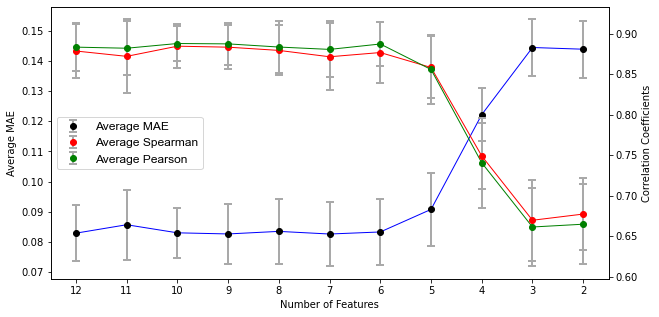

Input Parameters used: ['P_charged_centers', 'N_charged_centers', 'cLogP', 'cTPSA', 'Hbond_D', 'Hbond_A', 'Total_Carbon_Tails', 'Double_bonds', 'NP_ratio', 'Dlin-MC3_Helper lipid_ratio', 'Dlin-MC3+Helper lipid percentage', 'Chol_DMG-PEG_ratio']
# of Input Parameters used: 12
Number of Datapoints used: 720

################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.057, Hold_Out_MAE: 0.054,  Hold_Out_Spearman_Rank: 0.940, Hold_Out_Pearsons_R: 0.920, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 150, 'min_child_weight': 10.0, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.055, Hold_Out_MAE: 0.067,  Hold_Out_Spearman_Rank: 0

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.052, Hold_Out_MAE: 0.055,  Hold_Out_Spearman_Rank: 0.941, Hold_Out_Pearsons_R: 0.921, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.015, 'reg_alpha': 0.015, 'num_leaves': 16, 'n_estimators': 200, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.054, Hold_Out_MAE: 0.061,  Hold_Out_Spearman_Rank: 0.821, Hold_Out_Pearsons_R: 0.847, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 32, 'n_estimators': 500, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

#######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.055, Hold_Out_MAE: 0.057,  Hold_Out_Spearman_Rank: 0.936, Hold_Out_Pearsons_R: 0.918, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0.01, 'reg_alpha': 0, 'num_leaves': 64, 'n_estimators': 300, 'min_child_weight': 0.001, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.056, Hold_Out_MAE: 0.062,  Hold_Out_Spearman_Rank: 0.824, Hold_Out_Pearsons_R: 0.852, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.015, 'reg_alpha': 0, 'num_leaves': 32, 'n_estimators': 600, 'min_child_weight': 1.0, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

#############################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.058, Hold_Out_MAE: 0.053,  Hold_Out_Spearman_Rank: 0.929, Hold_Out_Pearsons_R: 0.924, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.005, 'reg_alpha': 0.01, 'num_leaves': 128, 'n_estimators': 600, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.054, Hold_Out_MAE: 0.062,  Hold_Out_Spearman_Rank: 0.800, Hold_Out_Pearsons_R: 0.843, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.005, 'reg_alpha': 0, 'num_leaves': 64, 'n_estimators': 400, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

#########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.056, Hold_Out_MAE: 0.054,  Hold_Out_Spearman_Rank: 0.940, Hold_Out_Pearsons_R: 0.922, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.005, 'reg_alpha': 0.01, 'num_leaves': 16, 'n_estimators': 250, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.053, Hold_Out_MAE: 0.061,  Hold_Out_Spearman_Rank: 0.830, Hold_Out_Pearsons_R: 0.855, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'num_leaves': 32, 'n_estimators': 300, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.060, Hold_Out_MAE: 0.062,  Hold_Out_Spearman_Rank: 0.920, Hold_Out_Pearsons_R: 0.909, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'num_leaves': 256, 'n_estimators': 250, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.056, Hold_Out_MAE: 0.068,  Hold_Out_Spearman_Rank: 0.824, Hold_Out_Pearsons_R: 0.827, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.015, 'num_leaves': 16, 'n_estimators': 600, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.070, Hold_Out_MAE: 0.061,  Hold_Out_Spearman_Rank: 0.904, Hold_Out_Pearsons_R: 0.909, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 600, 'min_child_weight': 0.001, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'goss'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.069, Hold_Out_MAE: 0.082,  Hold_Out_Spearman_Rank: 0.750, Hold_Out_Pearsons_R: 0.723, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.015, 'num_leaves': 128, 'n_estimators': 100, 'min_child_weight': 0.01, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

#####################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.113, Hold_Out_MAE: 0.116,  Hold_Out_Spearman_Rank: 0.638, Hold_Out_Pearsons_R: 0.608, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0.015, 'num_leaves': 128, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.111, Hold_Out_MAE: 0.122,  Hold_Out_Spearman_Rank: 0.493, Hold_Out_Pearsons_R: 0.386, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 64, 'n_estimators': 600, 'min_child_weight': 0.1, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'dart'}

######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.086, Hold_Out_MAE: 0.088,  Hold_Out_Spearman_Rank: 0.834, Hold_Out_Pearsons_R: 0.834, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 128, 'n_estimators': 500, 'min_child_weight': 0.1, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.085, Hold_Out_MAE: 0.107,  Hold_Out_Spearman_Rank: 0.617, Hold_Out_Pearsons_R: 0.630, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.005, 'reg_alpha': 0, 'num_leaves': 256, 'n_estimators': 200, 'min_child_weight': 0.001, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'goss'}

#############################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.116, Hold_Out_MAE: 0.114,  Hold_Out_Spearman_Rank: 0.467, Hold_Out_Pearsons_R: 0.727, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0.015, 'reg_alpha': 0.015, 'num_leaves': 256, 'n_estimators': 500, 'min_child_weight': 0.1, 'min_child_samples': 10, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.115, Hold_Out_MAE: 0.123,  Hold_Out_Spearman_Rank: 0.422, Hold_Out_Pearsons_R: 0.563, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.005, 'reg_alpha': 0.015, 'num_leaves': 128, 'n_estimators': 400, 'min_child_weight': 1.0, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

###################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.116, Hold_Out_MAE: 0.114,  Hold_Out_Spearman_Rank: 0.456, Hold_Out_Pearsons_R: 0.732, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.015, 'reg_alpha': 0.015, 'num_leaves': 64, 'n_estimators': 600, 'min_child_weight': 0.001, 'min_child_samples': 20, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.116, Hold_Out_MAE: 0.122,  Hold_Out_Spearman_Rank: 0.448, Hold_Out_Pearsons_R: 0.568, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.005, 'reg_alpha': 0.015, 'num_leaves': 128, 'n_estimators': 600, 'min_child_weight': 0.001, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

###############################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({


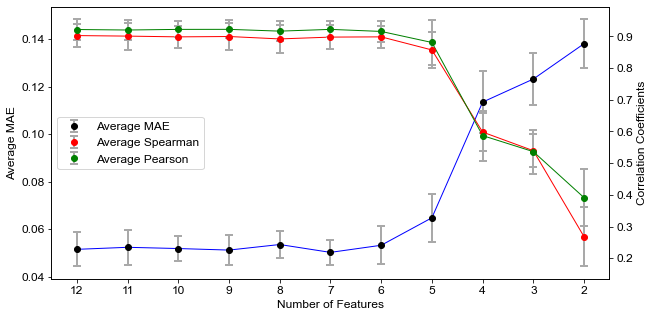

Input Parameters used: ['P_charged_centers', 'N_charged_centers', 'cLogP', 'cTPSA', 'Hbond_D', 'Hbond_A', 'Total_Carbon_Tails', 'Double_bonds', 'NP_ratio', 'Dlin-MC3_Helper lipid_ratio', 'Dlin-MC3+Helper lipid percentage', 'Chol_DMG-PEG_ratio']
# of Input Parameters used: 12
Number of Datapoints used: 1080

################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.062, Hold_Out_MAE: 0.068,  Hold_Out_Spearman_Rank: 0.681, Hold_Out_Pearsons_R: 0.889, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 256, 'n_estimators': 500, 'min_child_weight': 0.001, 'min_child_samples': 10, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.060, Hold_Out_MAE: 0.054,  Hold_Out_Spearman_Ra

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.061, Hold_Out_MAE: 0.061,  Hold_Out_Spearman_Rank: 0.701, Hold_Out_Pearsons_R: 0.912, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.015, 'reg_alpha': 0.01, 'num_leaves': 16, 'n_estimators': 500, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.062, Hold_Out_MAE: 0.052,  Hold_Out_Spearman_Rank: 0.653, Hold_Out_Pearsons_R: 0.887, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.015, 'reg_alpha': 0.005, 'num_leaves': 32, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.063, Hold_Out_MAE: 0.067,  Hold_Out_Spearman_Rank: 0.678, Hold_Out_Pearsons_R: 0.901, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.015, 'reg_alpha': 0.015, 'num_leaves': 256, 'n_estimators': 100, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.060, Hold_Out_MAE: 0.052,  Hold_Out_Spearman_Rank: 0.677, Hold_Out_Pearsons_R: 0.885, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0, 'num_leaves': 32, 'n_estimators': 500, 'min_child_weight': 0.01, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.061, Hold_Out_MAE: 0.065,  Hold_Out_Spearman_Rank: 0.721, Hold_Out_Pearsons_R: 0.898, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 600, 'min_child_weight': 1.0, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.063, Hold_Out_MAE: 0.053,  Hold_Out_Spearman_Rank: 0.684, Hold_Out_Pearsons_R: 0.875, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.005, 'num_leaves': 64, 'n_estimators': 250, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

###########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.058, Hold_Out_MAE: 0.063,  Hold_Out_Spearman_Rank: 0.723, Hold_Out_Pearsons_R: 0.903, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.015, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 150, 'min_child_weight': 1.0, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.061, Hold_Out_MAE: 0.051,  Hold_Out_Spearman_Rank: 0.650, Hold_Out_Pearsons_R: 0.898, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.015, 'num_leaves': 16, 'n_estimators': 400, 'min_child_weight': 1.0, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

###########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.060, Hold_Out_MAE: 0.064,  Hold_Out_Spearman_Rank: 0.728, Hold_Out_Pearsons_R: 0.896, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.015, 'reg_alpha': 0.01, 'num_leaves': 32, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.063, Hold_Out_MAE: 0.051,  Hold_Out_Spearman_Rank: 0.637, Hold_Out_Pearsons_R: 0.899, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 32, 'n_estimators': 400, 'min_child_weight': 10.0, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

##############################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.060, Hold_Out_MAE: 0.058,  Hold_Out_Spearman_Rank: 0.761, Hold_Out_Pearsons_R: 0.920, 

Best_Model_Params: 
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 16, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.062, Hold_Out_MAE: 0.049,  Hold_Out_Spearman_Rank: 0.654, Hold_Out_Pearsons_R: 0.908, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.015, 'reg_alpha': 0.015, 'num_leaves': 256, 'n_estimators': 400, 'min_child_weight': 10.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'dart'}

############################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.097, Hold_Out_MAE: 0.092,  Hold_Out_Spearman_Rank: 0.664, Hold_Out_Pearsons_R: 0.722, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.005, 'num_leaves': 64, 'n_estimators': 150, 'min_child_weight': 1.0, 'min_child_samples': 20, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.100, Hold_Out_MAE: 0.072,  Hold_Out_Spearman_Rank: 0.655, Hold_Out_Pearsons_R: 0.721, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.015, 'num_leaves': 64, 'n_estimators': 150, 'min_child_weight': 10.0, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'dart'}

############################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.080, Hold_Out_MAE: 0.071,  Hold_Out_Spearman_Rank: 0.685, Hold_Out_Pearsons_R: 0.875, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0.005, 'reg_alpha': 0.015, 'num_leaves': 128, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 10, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.081, Hold_Out_MAE: 0.062,  Hold_Out_Spearman_Rank: 0.476, Hold_Out_Pearsons_R: 0.851, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.01, 'num_leaves': 16, 'n_estimators': 150, 'min_child_weight': 0.1, 'min_child_samples': 2, 'learning_rate': 0.1, 'boosting_type': 'dart'}

##########################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.085, Hold_Out_MAE: 0.073,  Hold_Out_Spearman_Rank: 0.672, Hold_Out_Pearsons_R: 0.872, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.005, 'num_leaves': 16, 'n_estimators': 400, 'min_child_weight': 0.1, 'min_child_samples': 20, 'learning_rate': 0.1, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.086, Hold_Out_MAE: 0.066,  Hold_Out_Spearman_Rank: 0.423, Hold_Out_Pearsons_R: 0.812, 

Best_Model_Params: 
{'subsample': 0.4, 'reg_lambda': 0, 'reg_alpha': 0.01, 'num_leaves': 256, 'n_estimators': 600, 'min_child_weight': 0.001, 'min_child_samples': 40, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}

#######################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Best_Valid_Score: 0.119, Hold_Out_MAE: 0.128,  Hold_Out_Spearman_Rank: 0.343, Hold_Out_Pearsons_R: 0.407, 

Best_Model_Params: 
{'subsample': 0.8, 'reg_lambda': 0.005, 'reg_alpha': 0.01, 'num_leaves': 16, 'n_estimators': 600, 'min_child_weight': 0.001, 'min_child_samples': 20, 'learning_rate': 0.01, 'boosting_type': 'dart'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Best_Valid_Score: 0.124, Hold_Out_MAE: 0.095,  Hold_Out_Spearman_Rank: 0.322, Hold_Out_Pearsons_R: 0.439, 

Best_Model_Params: 
{'subsample': 0.6, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'num_leaves': 128, 'n_estimators': 600, 'min_child_weight': 10.0, 'min_child_samples': 20, 'learning_rate': 0.01, 'boosting_type': 'dart'}

################################################

C:\Users\enoch\AppData\Local\Temp\ipykernel_7060\2018374244.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({


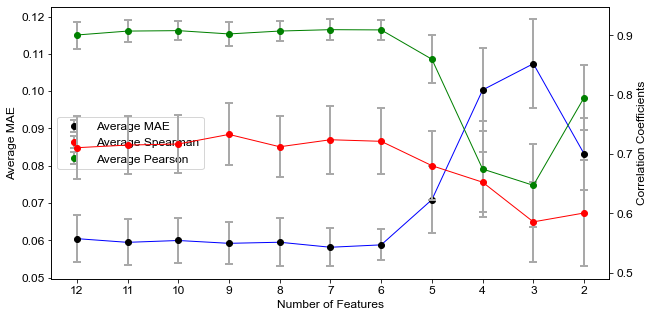

In [20]:
################ Model Training ##############################################
#####3. RETRAIN MODEL #####

cell_names = ['ARPE19','N2a','PC3','B16','HEK293','HepG2',]
wt_percent = False
size_zeta = False
N_CV = 10

save_path = "" # Where to save model, results, and training data
model_name = 'LGBM'

for cell_type_name in cell_names:
    stats_df = pd.DataFrame(columns=['Feature_No','Cluster Index','Cluster','Feature Preserved','Average MAE', 'Std MAE', 'Average Pearson', 'Std Pearson', 'Average Spearman', 'Std Spearman'])
    model_instance = run_NESTED_CV(model_name, data_file_path, save_path, cell_type_name, wt_percent, size_zeta, N_CV, input_param_names, 'All')
    average_mae, std_mae, average_pearson, std_pearson, average_spearman, std_spearman = model_instance.stats()
    Feature_No = len(input_param_names)
    stats_df = stats_df.append({
        'Feature_No': Feature_No,
        'Cluster Index': 0,
        'Cluster': 'All',
        'Feature Preserved': 'All',
        'Average MAE': average_mae,
        'Std MAE': std_mae,
        'Average Pearson': average_pearson,
        'Std Pearson': std_pearson,
        'Average Spearman': average_spearman,
        'Std Spearman': std_spearman
    }, ignore_index=True)


    reduced_params = input_param_names
    idx = 1; 
    for cluster in clusters: 
        best_feature = ''
        best_mae = 10000000000
        temp_params = input_param_names
        for feature in cluster:
            if feature in reduced_params:
                print('Feature Preserved in Cluster' + str(idx) + ": ", feature)
                features_to_exclude = [col for col in cluster if col not in feature]
                selected_columns = [col for col in reduced_params if col not in features_to_exclude]
                model_instance = run_NESTED_CV(model_name, data_file_path, save_path, cell_type_name, wt_percent, size_zeta, N_CV, selected_columns, feature)
                average_mae, std_mae, average_pearson, std_pearson, average_spearman, std_spearman = model_instance.stats()
                if average_mae < best_mae:
                    best_feature = feature
                    best_mae = average_mae
                    temp_params = selected_columns
        Feature_No = len(selected_columns)
        stats_df = stats_df.append({
        'Feature_No': Feature_No,
        'Cluster Index': idx,
        'Cluster': cluster,
        'Feature Preserved': best_feature,
        'Average MAE': average_mae,
        'Std MAE': std_mae,
        'Average Pearson': average_pearson,
        'Std Pearson': std_pearson,
        'Average Spearman': average_spearman,
        'Std Spearman': std_spearman
        }, ignore_index=True)
        reduced_params = temp_params
        idx += 1

    # save stats_df to csv
    with open(save_path + f'/{cell_type_name}/Feature_Reduction_Results.csv', 'w', encoding = 'utf-8-sig') as f: #Save file to csv
        stats_df.to_csv(f)
    plot_feature_reduction(stats_df, cell_type_name)


In [ ]:
###Print the results of Feature Reduction ###
print(stats_df)

# save stats_df to csv
with open(save_path + 'Feature_Reduction_Results.csv', 'w', encoding = 'utf-8-sig') as f: #Save file to csv
    stats_df.to_csv(f)
    


   Feature_No Cluster Index  \
0          12             0   
1          11             1   
2          10             2   
3           9             3   
4           8             4   
5           7             5   
6           6             6   
7           5             7   
8           4             8   
9           3             9   
10          2            10   

                                              Cluster  \
0                                                 All   
1                                    [cTPSA, Hbond_A]   
2                           [cTPSA, Hbond_A, Hbond_D]   
3                          [N_charged_centers, cLogP]   
4             [P_charged_centers, Total_Carbon_Tails]   
5   [cTPSA, Hbond_A, Hbond_D, N_charged_centers, c...   
6   [P_charged_centers, Total_Carbon_Tails, Double...   
7             [NP_ratio, Dlin-MC3_Helper lipid_ratio]   
8   [NP_ratio, Dlin-MC3_Helper lipid_ratio, Dlin-M...   
9   [NP_ratio, Dlin-MC3_Helper lipid_ratio, Dlin-M...   
